# Initializing and Preprocessing
Load up experiment & annotations

In [1]:
#import sys
#sys.path.append("/tmp/pycharm_project_XXX/")
#sys.path.append("/tmp/pycharm_project_XXX/src/")

%load_ext autoreload
%autoreload 2


import pandas as pd
from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_multiclass_test_one_handed, \
    preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction
from preprocessing._segmentation import segment_for_null_classification, segment_windows
from visualization._visualization import swarm_plot_top_features

from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from visualization import plot_duration_histogram
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters

sample_rate = 50


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [15]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Ariane","Julian","Wiktoria"]
#experiment_dirs_selected = ["Julius"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]

selected_activities = ["washing hands", "drying hands"] # set to None if you want to classify between all activities


Preprocess data

In [5]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True, selected_activities=selected_activities)

In [ ]:
plot_duration_histogram(chunks["right"])
plot_duration_histogram(null_chunks["right"])

# append the action id to the dataframe
# we need to do this to be able to extract time series features later
# Preprocess data

In [12]:
chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks, use_indoor=use_indoor)

In [14]:
chunks_ocd[0]

,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right,action_id
index,,,,,,,,,,,,,
00:00:45.195424,0.080842,-0.652570,-0.745546,-1.688645,10.009453,1.528304,0.212193,0.589279,0.025491,4.278438,3.879274,7.106298,0
00:00:45.215424,0.055093,-0.162409,-1.073608,-1.143220,10.598500,2.107034,0.200053,0.466338,-0.085046,4.407363,3.974909,6.969913,0
00:00:45.235424,-0.058202,0.297700,-1.544176,-0.679525,10.945311,2.082346,0.227174,0.383582,-0.168461,4.540861,4.167423,7.014442,0
00:00:45.255424,-0.207035,0.473459,-2.010919,-1.267741,11.046615,1.675375,0.290634,0.389065,-0.229895,4.370850,4.338073,7.168862,0
00:00:45.275424,-0.329001,0.559849,-2.409831,-2.756085,11.373989,1.762649,0.346851,0.442789,-0.279890,3.965375,4.576073,7.409380,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:49.395424,0.049198,0.458295,0.128294,-3.828648,-4.237888,8.278369,-0.072563,0.004929,-0.085579,5.451789,4.529566,6.949585,0
00:00:49.415424,-0.049144,0.317507,0.112490,-4.117091,-4.317545,7.831544,-0.078282,-0.033560,-0.090486,5.451187,4.567707,6.860704,0
00:00:49.435424,-0.091444,0.124458,0.109181,-4.320836,-4.468082,7.605123,-0.089473,-0.062057,-0.088470,5.433068,4.573440,6.765505,0


### Segmentation


In [35]:
# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


## Binary Classification: OCD activities vs null class samples
### Feature extraction for OCD activities vs non-OCD activities

In [43]:

X_null_class_classification = extract_timeseries_features(null_classification_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


### Feature selection

In [44]:

impute(X_null_class_classification)
X_null_classification_selected = select_features(X_null_class_classification, labels_null_classification)

In [45]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [ ]:
labels_null_classification.values

### Train models and score results

In [46]:
print("Binary classification")
classify_all(X_null_classification, labels_null_classification)

Binary classification
Logistic Regression: 0.58 +/- 0.10
LDA: 0.58 +/- 0.10
LinearSVC: 0.58 +/- 0.09
CART: 0.46 +/- 0.09
Random Forest: 0.45 +/- 0.11
NB: 0.55 +/- 0.06


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

KeyboardInterrupt: 

In [ ]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

Process ForkPoolWorker-53:
Process ForkPoolWorker-56:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:
Process ForkPoolWorker-49:
Process ForkPoolWorker-55:
Process ForkPoolWorker-50:
Traceback (most recent call last):
Traceback (most recent call last):


   index         class                      features     value
0      0  OCD activity  acceleration z_right__median  0.786816
1      1  OCD activity  acceleration z_right__median  0.708061
2      2  OCD activity  acceleration z_right__median  0.706495
3      3  OCD activity  acceleration z_right__median  0.685359
4      4  OCD activity  acceleration z_right__median  0.126383


KeyboardInterrupt: 

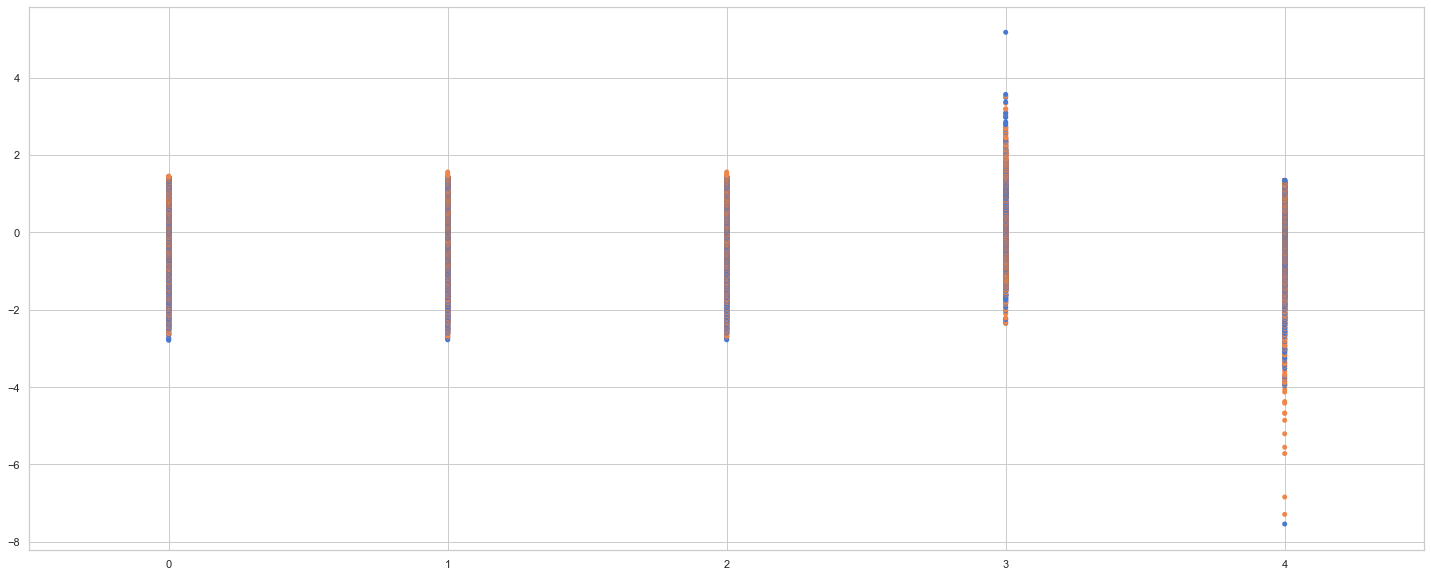

In [47]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_null_classification_selected.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())


# Multiclass classification

For the multi class classification we can reuse
- data loading
- preprocessing
- segmentation

We mainly need to:
- re label the OCD segments with the y array
- do the segmentation for the ocd chunks again
- extract features again
- select and scale features again
- classify again
- visualize results again

In [ ]:
# make sure we've already run the segmentation for the binary classification earlier

assert len(labels_null_segmented) != 0
labels = y.loc[:, "label"].squeeze()
labels_ocd_multiclass = labels.reset_index(drop=True)
_, labels_ocd_segmented_multiclass = segment_windows(chunks_ocd, labels_ocd_multiclass.to_numpy(), window_size)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

In [ ]:
# reuse chunks_ocd_segmented from the segmentation for the binary classifier
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

# with null class
mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])

# without null class
"""
mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented_multiclass])
"""
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

In [ ]:
labels_multi_class_classification = labels_multi_class_classification.str.replace("  ", " ").str.strip()

assert set(labels_multi_class_classification) == {'checking oven',
 'cleaning cup',
 'cleaning floor',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'drying hands',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',
 'sitting down',
 'standing up',
 'walking',
 'washing hands'}

In [ ]:
X_multi_class_classification = extract_timeseries_features(mulit_class_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

In [ ]:
impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)

In [ ]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

In [ ]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique()[0:16], ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

sne_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])